In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import methods
import pymaster as nmt
from importlib import reload
from tqdm import tqdm

In [2]:
nside = 1024
npix = 12*nside**2
lmax = 3*nside-1
n_sims = 10

In [3]:
# m_input_vec = np.empty((n_sims, 3, npix))
# m_res_vec = np.empty_like(m_input_vec)
# for i in range(n_sims):
#     alm = [hp.read_alm(f'npipe6v20_sim/input/ffp10_cmb_143_alm_mc_020{i}.fits', hdu=j) for j in range(1,4)]
#     m_input_vec[i] = 1e6 * hp.alm2map(alm, nside) 
#     m_res_vec[i] = 1e6 * hp.ud_grade(hp.read_map(f'npipe6v20_sim/res/residual_npipe6v20_143_020{i}.fits', field=None), nside)
    
# np.save(f'sims/m_input_vec_{nside}', m_input_vec)
# np.save(f'sims/m_res_vec_{nside}', m_res_vec)

In [21]:
m_input_vec = np.load(f'sims/m_input_vec_{nside}.npy')
m_res_vec = np.load(f'sims/m_res_vec_{nside}.npy')

In [22]:
reload(methods)
mask = methods.get_mask(nside)
mask_apo = nmt.mask_apodization(mask, 2.5, apotype='Smooth')
np.save(f'sims/mask_apo_{nside}', mask_apo)

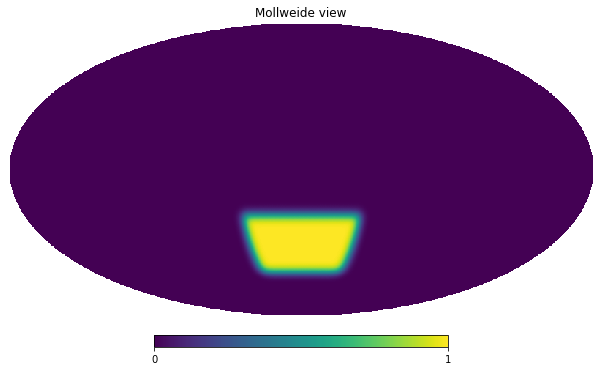

In [22]:
mask_apo = np.load(f'sims/mask_apo_{nside}.npy')
hp.mollview(mask_apo)

In [23]:
reload(methods)
sigmab = hp.nside2resol(nside)
fwhm = methods.sigma2fwhm(sigmab)
bl = methods.get_bl(nside)
b = nmt.NmtBin.from_nside_linear(nside, 16)
ells = b.get_effective_ells()
P_bl = methods.get_P_bl(ells, nside)

In [24]:
cl_KS = np.zeros((n_sims, 4, len(ells)))
anafast = np.zeros((n_sims, 3, lmax+1))

input_cl = np.zeros((n_sims, 3, lmax+1))

for i in tqdm(range(n_sims)):
    input_map = m_input_vec[i]
    smoothed_input_map = hp.smoothing(input_map, fwhm)
    input_cl[i] = hp.anafast(smoothed_input_map, nspec=3)/bl**2
    f = nmt.NmtField(mask_apo, [smoothed_input_map[1], smoothed_input_map[2]], beam=bl, purify_b=True)
    cl_KS[i] = nmt.compute_full_master(f, f, b)
    
    patch_map = mask_apo * smoothed_input_map
    noisy_external_map = (1-mask_apo) * (input_map + m_res_vec[i])
    smoothed_noisy_external_map = hp.smoothing(noisy_external_map, fwhm)
    anafast[i] = hp.anafast(patch_map + smoothed_noisy_external_map, nspec=3) / bl**2

In [25]:
anafast_binned = np.zeros((n_sims, 3, len(ells)))
input_binned = np.zeros((n_sims, 3, len(ells)))
for i in range(n_sims):
    for j in range(3):
        anafast_binned[i][j] = P_bl @ anafast[i][j]
        input_binned[i][j] = P_bl @ input_cl[i][j]

In [26]:
c2d = ells * (ells+1) /2/np.pi

mean_KS = c2d*np.mean(cl_KS, axis=0)
std_KS = c2d*np.std(cl_KS, axis=0)

mean_full = c2d*np.mean(anafast_binned, axis=0)
std_full = c2d*np.std(anafast_binned, axis=0)

mean_input = c2d*np.mean(input_binned, axis=0) 
std_input = c2d*np.std(input_binned, axis=0)

In [27]:
ell_input, TT, TE, EE, BB, PP = np.loadtxt('cl.txt', unpack=True)

[]

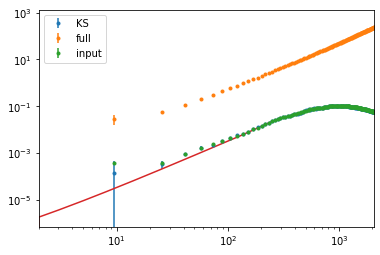

In [31]:
ind = 2
if ind==1: nmt_ind=0
if ind==2: nmt_ind=3
    
plt.errorbar(ells, mean_KS[nmt_ind], yerr=std_KS[nmt_ind], fmt='.', label='KS')
plt.errorbar(ells, mean_full[ind], yerr=std_full[ind], fmt='.', label='full')
plt.errorbar(ells, mean_input[ind], yerr=std_input[ind], fmt='.', label='input')
plt.plot(BB)
plt.plot()
plt.legend()
plt.xlim([2,2*nside])
plt.loglog()

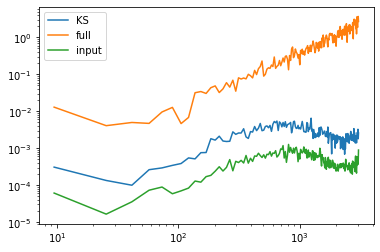

In [29]:
plt.plot(ells, std_KS[3], label='KS')
plt.plot(ells, std_full[2], label='full')
plt.plot(ells, std_input[2], label='input')

plt.loglog()
plt.legend()